## ML tests on Conical debris bed COCOMO simulations
#### ++++++
#### Author: Jasmin Joshi-Thompson
#### jasminjthompson@gmail.com
#### ++++++

## Workflow
1. Import sim results consiting of 
    - time  detected  SIM_ID      Psys  Ffuel  Porosity Dparticle  Alpha  Rflat    Tbed    Decay  Fstruct  
2. Normlaise and pred (1,0) quench or melt
3. Import quench front matrix
4. use NN to predict matrix from inputs

### Part 2: predicting the qunching time as a scalar value
1. take results from model 1: simulation end condition
2. Predict the quenching time 
( Questions to ask, if you have a limit detection, do you identify the limit as a classifier and then regression, or add all the data together and predict the limit as part of the regression model)

In [29]:
# Standard library imports
import os
import sys
import time
import io
from datetime import datetime
import math

# Third-party library imports
import numpy as np
import ast
import pandas as pd

import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from adjustText import adjust_text
from fpdf import FPDF
from scipy import signal
from scipy.signal import argrelextrema, find_peaks, savgol_filter
import seaborn as sns
import joblib
import keras
import tensorflow as tf
import keras_tuner
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import RepeatedKFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, recall_score, f1_score, precision_score, roc_curve

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.utils import resample
import matplotlib.colors as colors
from matplotlib import gridspec
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


# Tkinter imports
import tkinter as tk
from tkinter import filedialog, simpledialog
from tkinter.filedialog import askdirectory

# Placeholder for functions and other custom imports
# import h5py
# from keras.models import load_model
# import sns
# import simpledialog


      time  detected               SIM_ID      Psys  Ffuel  Porosity  \
0  5730.63    melted  batchlocal1_run0000  168500.0  0.865    0.3525   
1  1330.06  quenched  batchlocal1_run0001  402500.0  0.635    0.4275   

   Dparticle  Alpha  Rflat    Tbed    Decay  Fstruct  
0    0.00184   17.1   1.18  1219.0  0.00825   1.0025  
1    0.00456   24.9   0.78  1453.0  0.00405   1.4575  


<Axes: xlabel='detected'>

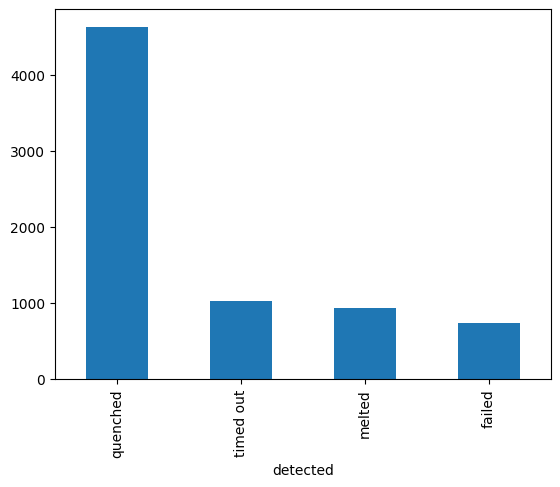

In [30]:
# open data
df = pd.read_csv(r"D:\Users\ikejjosh\Documents\COCOMO\debris_cone\sim_results.csv")
print(df.head(2))
#make histogram of detected columns for categorical data
df['detected'].value_counts().plot(kind='bar')
#replace 

In [31]:
# print the first 5 rows of the df where time is less than 0.5
#print(df[df['time'] < 500])
# remove all rows where time is less than 100 as they hold high statistical error
df = df[df['time'] > 100]
## reset the index
df = df.reset_index(drop=True)
#

In [32]:
# print the totoal in each cataegory
print(df['detected'].value_counts())
# get the percentage of failed + timeout / total
#print((df['detected'].value_counts()[1] + df['detected'].value_counts()[3]) / df['detected'].count())


detected
quenched     4530
timed out    1028
melted        939
Name: count, dtype: int64


In [33]:
# drop all rows that timed out or failed
df = df[df.detected != 'failed']

df = df[df.detected != 'timed out']

### Decision weather timed out scenario is a melting scenario
- Timed out is when the simulation hits 7200 seconds without quenching. This is a terminus for the simulation
- This could skew the prediction results as timing out is not a melting contidion, making the result non-continuious
- timed out could be added as a catagorical predictor - which is then passed on as a regression model for predicting the maximum quenching time

In [34]:
#convert catagorical data to numerical
df['detected'] = df['detected'].map({'quenched': 1, 'melted': 0})
df = df.drop(columns=['SIM_ID', 'detected'])
df.isnull().sum()
# drop all rows with nan values
df = df.dropna()

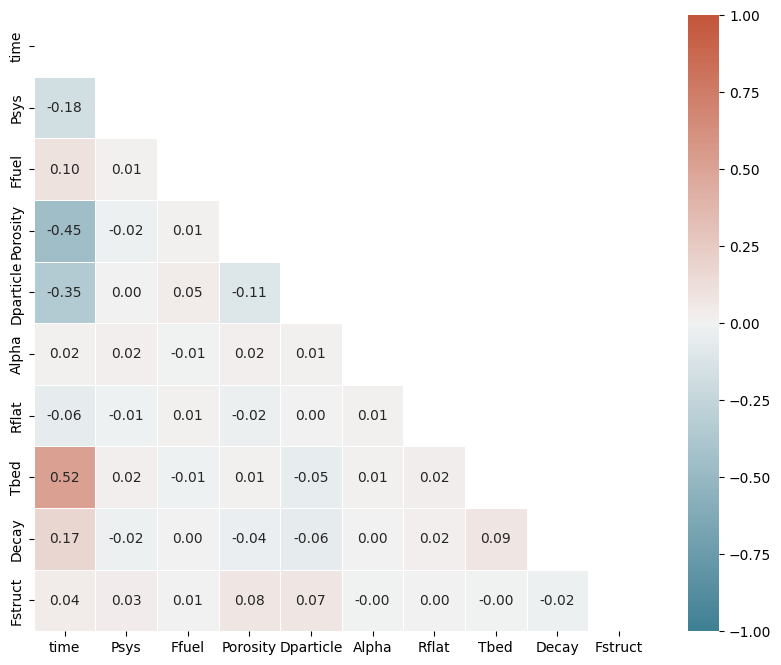

In [35]:
corr = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", ax=ax)

plt.show()


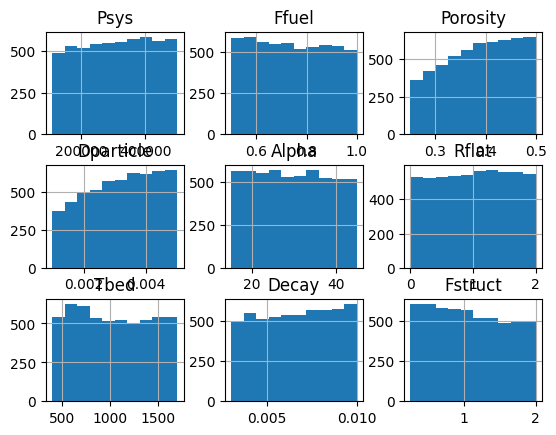

In [36]:
# Define features and labels
X = df.drop(columns='time')
y = df['time']
# make y a df
y = pd.DataFrame(y)
# plot distribution of each variable in X
X.hist()
plt.show()



In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# save data to csv
#X_train.to_csv('X_train.csv', index=False)
#X_test.to_csv('X_test.csv', index=False)
#y_train.to_csv('y_train.csv', index=False)
#y_test.to_csv('y_test.csv', index=False)


# normalise date
scaler = MinMaxScaler()
# save the scaler to file 


X_train = scaler.fit_transform(X_train)
# Check if the file exists, if it does, replace it; otherwise, create a new one
if os.path.exists('MinMaxScaler_X.pkl'):
    os.remove('MinMaxScaler_X.pkl')
joblib.dump(scaler, 'MinMaxScaler_X.pkl')
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

scalar_y = MinMaxScaler()
# save the scaler to file

y_train = scalar_y.fit_transform(y_train)
if os.path.exists('MinMaxScaler_y.pkl'):
    os.remove('MinMaxScaler_y.pkl')
joblib.dump(scalar_y, 'MinMaxScaler_y.pkl')
y_test = scalar_y.transform(y_test)
y_val = scalar_y.transform(y_val)

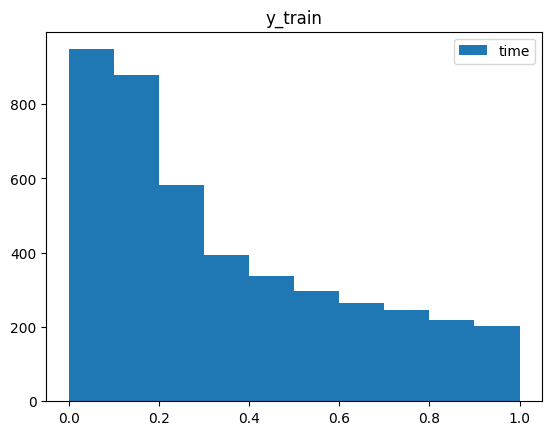

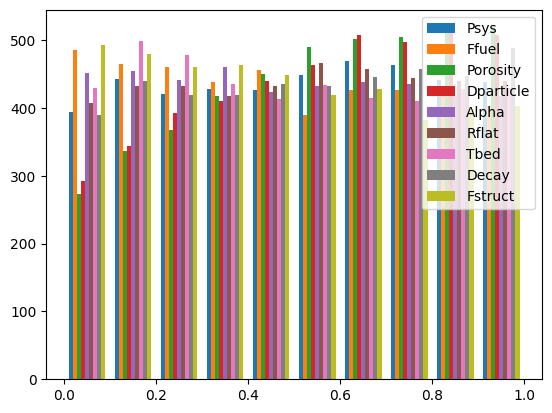

In [38]:
# print distrbution of X and y
plt.hist(y_train) # time 
plt.legend(y.columns)
plt.title('y_train')
plt.show()
plt.hist(X_train)
plt.legend(X.columns)
plt.show()


### Build the model and test

In [39]:

# Define a function to build the model
# log scale the data before training

def build_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='gelu'))
    model.add(Dense(120, activation='gelu'))
    model.add(Dense(64, activation='gelu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='gelu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='gelu'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    return model

# Ensemble settings
n_models = 5
predictions = []

for i in range(n_models):
    print(f"Training model {i+1}/{n_models}")
    #set new random seed
    np.random.seed(i)
    model = build_model(X_train.shape[1])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0)
    # save model
    model.save(f"model_{i+1}.keras")
    y_pred = model.predict(X_test)
    # guve score
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f"Model {i+1} score: {score[0]}")
    y_pred = scalar_y.inverse_transform(y_pred)
   
    predictions.append(y_pred.ravel())

# Convert to numpy array for analysis
predictions = np.array(predictions)

# Mean and std dev of predictions
y_pred_mean = predictions.mean(axis=0)
y_pred_std = predictions.std(axis=0)

# Inverse transform the true y_test
y_test_inv = scalar_y.inverse_transform(y_test)


# Metrics
print('mean squared error:', mean_squared_error(y_test_inv, y_pred_mean))
print('mean absolute error:', mean_absolute_error(y_test_inv, y_pred_mean))
print('mean absolute percentage error:', mean_absolute_percentage_error(y_test_inv, y_pred_mean))

print('r2 score:', r2_score(y_test_inv, y_pred_mean))



Training model 1/5


d:\Users\ikejjosh\Documents\COCOMO\06_NNs\debris_cone\REGRESSION_APP\venv_app\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 1 score: 0.001265261322259903
Training model 2/5


d:\Users\ikejjosh\Documents\COCOMO\06_NNs\debris_cone\REGRESSION_APP\venv_app\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 2 score: 0.0011943684658035636
Training model 3/5


d:\Users\ikejjosh\Documents\COCOMO\06_NNs\debris_cone\REGRESSION_APP\venv_app\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 3 score: 0.0010364686604589224
Training model 4/5


d:\Users\ikejjosh\Documents\COCOMO\06_NNs\debris_cone\REGRESSION_APP\venv_app\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 4 score: 0.0013429875252768397
Training model 5/5


d:\Users\ikejjosh\Documents\COCOMO\06_NNs\debris_cone\REGRESSION_APP\venv_app\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 5 score: 0.0010640406981110573
mean squared error: 50150.45344119982
mean absolute error: 121.94026117233473
mean absolute percentage error: 0.0501716469093208
r2 score: 0.9867985230339567


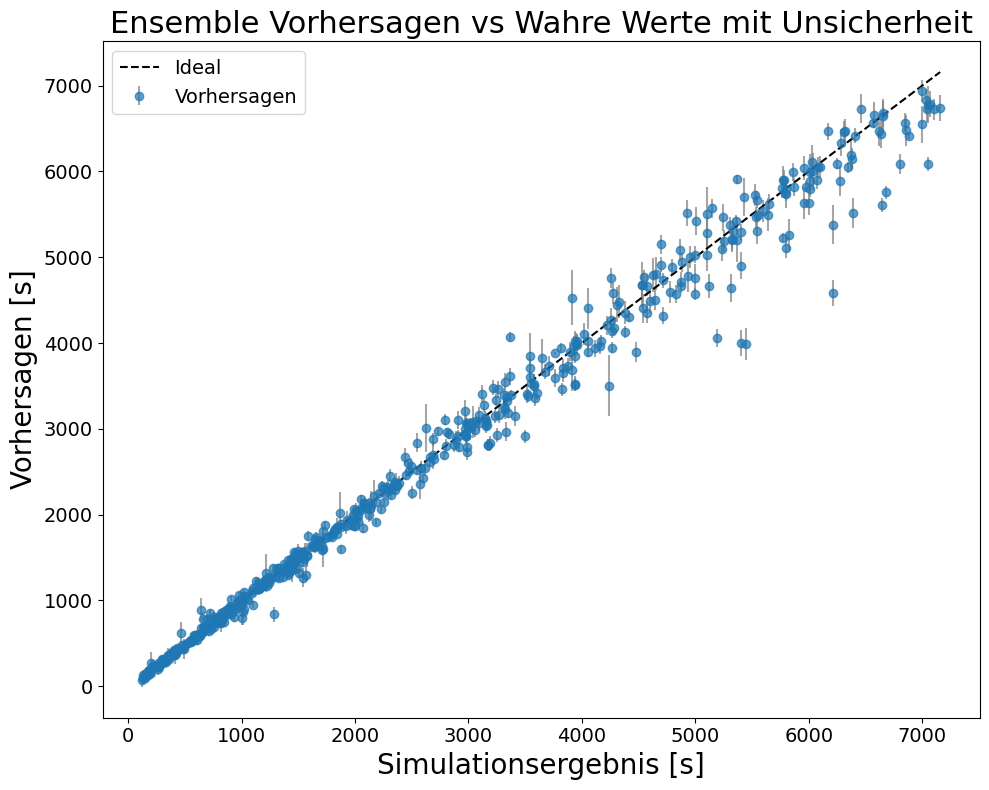

In [40]:
# Plot
plt.figure(figsize=(10, 8))  # Slightly larger for better readability
plt.errorbar(y_test_inv, y_pred_mean, yerr=y_pred_std, fmt='o', ecolor='gray', alpha=0.7, label='Vorhersagen')
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], '--k', label='Ideal')
fs =20
# Bigger fonts
plt.xlabel('Simulationsergebnis [s]', fontsize=fs)
plt.ylabel('Vorhersagen [s]', fontsize=fs)
plt.title('Ensemble Vorhersagen vs Wahre Werte mit Unsicherheit', fontsize=fs+2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()



### Complete test of run time

In [41]:
# how long does it take to run
start_time = time.time()
# run predictions
pred = model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")
# time per prediction
print(f"Time per prediction: {execution_time / len(X_test)} seconds")
print(f"number of predictions: {len(X_test)}")  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Execution time: 0.056702613830566406 seconds
Time per prediction: 0.00010366108561346693 seconds
number of predictions: 547
